In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib.pyplot import imshow

In [2]:
EMBED_SIZE = 50
SEQ_LENGHT = 20
BATCH_SIZE = 16

In [3]:
x = torch.rand(BATCH_SIZE, SEQ_LENGHT, EMBED_SIZE)
x.shape

torch.Size([16, 20, 50])

In [5]:
class SelfAttention(nn.Module):
    def __init__(self, seq_lenght, embed_dim, batch_size):
        super().__init__()
        self.seq = seq_lenght
        self.embed = embed_dim
        self.batch = batch_size
        self.transform_q = nn.Linear(self.embed, self.embed)
        self.transform_k = nn.Linear(self.embed, self.embed)
        self.transform_v = nn.Linear(self.embed, self.embed)
        return None
    def forward(self, x):
        b, s, e = x.size()
        q = self.transform_q(x)
        k = self.transform_q(x)
        v = self.transform_q(x)
        out, w = self.scaled_dot_attention(q,k,v)
        return out, w.detach().numpy()
    def scaled_dot_attention(self, q,k,v):
        raw_w = torch.bmm(q, k.transpose(1,2))
        raw_w = raw_w / np.sqrt(self.embed)
        w = F.softmax(raw_w, dim=2)
        out = torch.bmm(w,v)
        return out, w

In [6]:
attn = SelfAttention(SEQ_LENGHT, EMBED_SIZE, BATCH_SIZE)

In [7]:
o, w = attn(x)

In [8]:
o.shape, w.shape

(torch.Size([16, 20, 50]), (16, 20, 20))

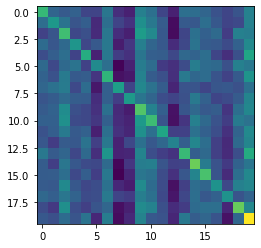

In [9]:
imshow(w[0])

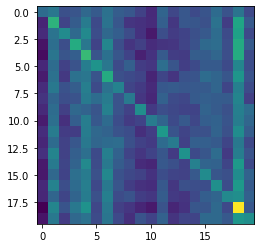

In [10]:
imshow(w[1])

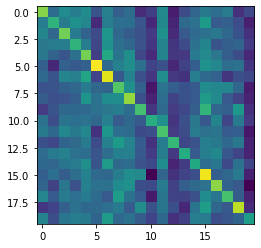

In [11]:
imshow(w[2])

## Pure Self Attention

In [12]:
def self_attn(x):
    b, h, e = x.size()
    raw_w = torch.bmm(x, x.transpose(1,2))
    w = F.softmax(raw_w, dim=2)
    y = torch.bmm(w, x)
    return y, w

In [13]:
def scaled_self_attn(x):
    b, h, e = x.size()
    raw_w = torch.bmm(x, x.transpose(1,2))
    raw_w = raw_w / np.sqrt(e)
    w = F.softmax(raw_w, dim=2)
    y = torch.bmm(w, x)
    return y, w

In [14]:
x.shape

torch.Size([16, 20, 50])

In [15]:
o, w = scaled_self_attn(x)

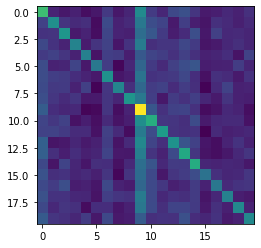

In [16]:
imshow(w[0])

In [17]:
o, w = self_attn(x)

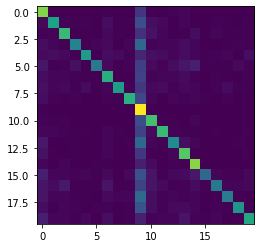

In [18]:
imshow(w[0])

## Important properties
1. Up to start training, there are no parameters yet. They are learned when we plug in the downstream task, so that it is related to the specific task
2. Self attention sees the input as a **_set_**, not a sequence (permutation equivariant)


## Multi-Head Attention
- Option to give the network more abstraction power
- Narrow or wide self attention
    - **Narrow** - divide the embedding matrix by the number of attention heads (e.g. $W_{q}^{r}$, $W_{k}^{r}$, $W_{v}^{r}$) if W is 256, each head with be 32 dimension
    - **Wide** - embedding matrix is complete 256x256 dimension

In [159]:
class MultiHeadAttention_1(nn.Module):
    def __init__(self, seq_lenght, embed_dim, batch_size, num_heads=8):
        super().__init__()
        self.seq = seq_lenght
        self.embed = embed_dim
        self.batch = batch_size
        self.num_heads = num_heads
        self.transform_q = nn.Linear(self.embed, self.num_heads * self.embed) ## 50 x 400
        self.transform_k = nn.Linear(self.embed, self.num_heads * self.embed) ## 50 x 400
        self.transform_v = nn.Linear(self.embed, self.num_heads * self.embed) ## 50 x 400
        self.unify_heads = nn.Linear(self.num_heads * self.embed, self.embed) ## 400 x 50
        
    def forward(self, x):
        b, s, e = x.size()
        q = self.transform_q(x)
        k = self.transform_k(x)
        v = self.transform_v(x)
        print(q.shape)
        out, w = self.scaled_dot_attention(q,k,v)
        return out, w.detach().numpy()
    
    def scaled_dot_attention(self, q,k,v):
        raw_w = torch.bmm(q, k.transpose(1,2))
        raw_w = raw_w / np.sqrt(self.embed)
        w = F.softmax(raw_w, dim=2)
        out = torch.bmm(w,v)
        print(out.shape)
        out = self.unify_heads(out)
        print(out.shape)
        return out, w

class MultiHeadAttention(nn.Module):
    def __init__(self, seq_lenght, embed_dim, batch_size, num_heads=8):
        super().__init__()
        self.seq = seq_lenght
        self.embed = embed_dim
        self.batch = batch_size
        self.num_heads = num_heads
        self.transform_q = nn.Linear(self.embed, self.num_heads * self.embed) ## 50 x 400
        self.transform_k = nn.Linear(self.embed, self.num_heads * self.embed) ## 50 x 400
        self.transform_v = nn.Linear(self.embed, self.num_heads * self.embed) ## 50 x 400
        self.unify_heads = nn.Linear(self.num_heads * self.embed, self.embed) ## 400 x 50
        
    def forward(self, x):
        b, s, e = x.size()
        q = self.transform_q(x).view(b, s, self.num_heads, e) ## 16 x 20 x 8 x 50
        k = self.transform_k(x).view(b, s, self.num_heads, e)
        v = self.transform_v(x).view(b, s, self.num_heads, e)
        k = k.transpose(1, 2).contiguous().view(b * self.num_heads, s, e) ## 128 x 20 x 50
        q = q.transpose(1, 2).contiguous().view(b * self.num_heads, s, e)
        v = v.transpose(1, 2).contiguous().view(b * self.num_heads, s, e)
        out, w = self.scaled_dot_attention(q,k,v)
        return out, w.detach().numpy()
    
    def scaled_dot_attention(self, q,k,v):
        raw_w = torch.bmm(q, k.transpose(1,2))
        raw_w = raw_w / np.sqrt(self.embed)
        w = F.softmax(raw_w, dim=2)
        out = torch.bmm(w,v).view(self.batch, self.num_heads, self.seq, self.embed)
        out = out.transpose(1, 2).contiguous().view(self.batch,  self.seq, self.num_heads * self.embed)
        out = self.unify_heads(out)
        return out, w

In [160]:
EMBED_SIZE = 50
SEQ_LENGHT = 20
BATCH_SIZE = 16
NUM_HEADS = 8

In [161]:
att_1 = MultiHeadAttention_1(SEQ_LENGHT, EMBED_SIZE, BATCH_SIZE, NUM_HEADS)
att_2 = MultiHeadAttention(SEQ_LENGHT, EMBED_SIZE, BATCH_SIZE, NUM_HEADS)

In [162]:
x = torch.randn(BATCH_SIZE, SEQ_LENGHT, EMBED_SIZE)
x.shape

torch.Size([16, 20, 50])

In [163]:
o_1, w_1 = att_1(x)
o_2, w_2 = att_2(x)

torch.Size([16, 20, 400])
torch.Size([16, 20, 400])
torch.Size([16, 20, 50])


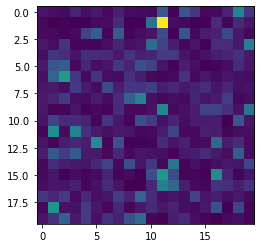

In [164]:
imshow(w_1[0])

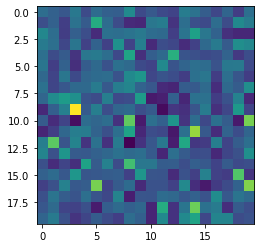

In [165]:
imshow(w_2[0])

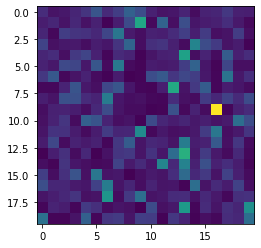

In [166]:
imshow(w_1[1])

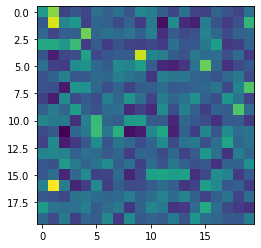

In [167]:
imshow(w_2[1])

## Transformer Block

In [171]:
!ls figures/

big_o_1.png                  naive_bayes_1.png
big_o_2.png                  naive_bayes_2.png
big_o_3.png                  transformer-block.svg
hash_table_1.png             trees_1.png
heap_1.png                   tries_1.png
heap_2.png                   tries_2.png
hierachical_clustering_1.png tries_3.png
hierachical_clustering_2.png


<img src="figures/transformer-block.svg" width=640/>


In [273]:
class TransformerBlock(nn.Module):
    def __init__(self, seq_lenght, embed_dim, batch_size, num_heads=8):
        super().__init__()
        self.seq = seq_lenght
        self.embed = embed_dim
        self.batch = batch_size
        self.num_heads = num_heads
        self.attn = MultiHeadAttention(self.seq, self.embed, self.batch, self.num_heads)
        
        self.norm1 = nn.LayerNorm(self.embed)
        self.norm2 = nn.LayerNorm(self.embed)
        self.drop = nn.Dropout(0.2)
        
        self.mlp = nn.Linear(self.embed, self.embed)
        
    def forward(self, x):
        x, w = self.attn(x)
        x+= x              ## Residual
        x = self.norm1(x)  ## Layer Norm 1
        x = self.drop(x)   ## Dropout
        x = self.mlp(x)+x  ## Residual
        x = self.norm2(x)  ## Layer Norm 2
        x = self.drop(x)   ## Dropout
        return x, w

In [274]:
EMBED_SIZE = 50
SEQ_LENGHT = 20
BATCH_SIZE = 16
NUM_HEADS = 8

In [275]:
transformer_blk = TransformerBlock(SEQ_LENGHT, EMBED_SIZE, BATCH_SIZE, NUM_HEADS)

In [276]:
x = torch.randn(BATCH_SIZE, SEQ_LENGHT, EMBED_SIZE)
x.shape

torch.Size([16, 20, 50])

In [277]:
o, w = transformer_blk(x)

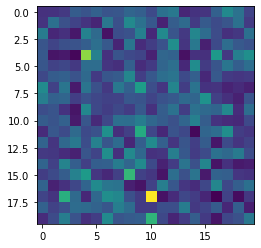

In [278]:
imshow(w[1])

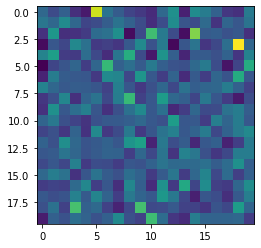

In [279]:
imshow(w[-1])